In [2]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
import sys
from analyse_distortion import reduce_1d
%matplotlib notebook
%load_ext autoreload

# Edge Finding Development
I've previously been finding the edge in edge images by:
1. Determining whether the edge is horizontal-ish or vertical-ish, and rising or falling, by:
    - Computing the maximum and minimum gradient in each direction (with smoothing)
    - Determining which max/min value is furthest from zero
2. Finding the maximum gradient along each column of the image (after suitably flipping/transposing)
3. Fitting a line to the resulting y value for each x value

This is not terribly robust.  How to do better...

In [4]:
from extract_raw_image import load_raw_image

thumbnails = []
rgb_images = []
folder = "datasets/ac127_100x_plan/vertical_edge_zstacks/centre/"
fnames = [f for f in os.listdir(folder) if f.startswith("edge_zstack") and f.endswith(".jpg") and "raw" in f]
for f in fnames:
    bayer_array = load_raw_image(os.path.join(folder, f))
    rgb_image = (bayer_array.demosaic()//4).astype(np.uint8)
    rgb_images.append(rgb_image)
    thumbnail = reduce_1d(reduce_1d(rgb_image, 4, axis=0), 4, axis=1).astype(np.uint8)
    thumbnails.append(thumbnail)
    

<IPython.core.display.Javascript object>


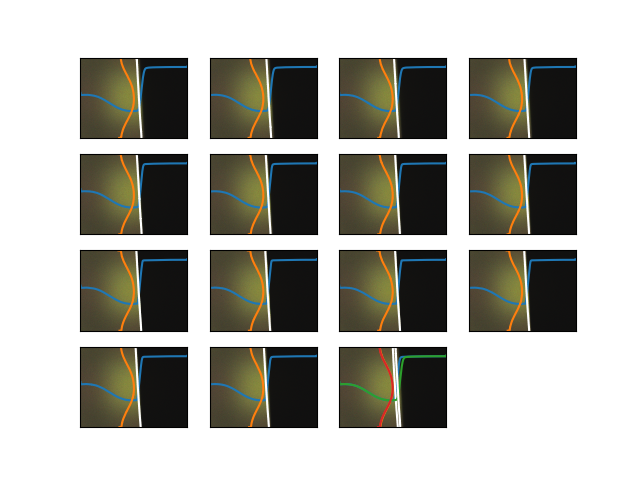

In [42]:
from analyse_distortion import find_edge_orientation, find_edge
from analyse_edge_image import reorient_image

fig = plt.figure()
for i, thumbnail in enumerate(thumbnails):
    # Plot the image
    ax = fig.add_subplot((len(thumbnails) - 1)// 4 + 1, 4, i + 1)
    ax.imshow(thumbnail)
    
    # Plot the marginal distributions
    w, h = thumbnail.shape[:2]
    xmarginal = np.mean(np.mean(thumbnail, axis=2), axis=0)
    ymarginal = np.mean(np.mean(thumbnail, axis=2), axis=1)
    ax.plot(range(h), xmarginal/xmarginal.max()*h/2)
    ax.plot(ymarginal/ymarginal.max()*h/2, range(w))
    
    # tidy up the plot (hide axes)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    # Find the line (old method)
    horizontal, falling = find_edge_orientation(thumbnail)
    flipped = reorient_image(thumbnail, not horizontal, not falling) # why the nots???!
    xs, ys = find_edge(flipped.sum(axis=2))
    if horizontal:
        xs, ys = ys, xs
    if falling:
        xs, ys = xs[::-1], ys[::-1]
    ax.plot(xs, ys, color="white")
    

<IPython.core.display.Javascript object>


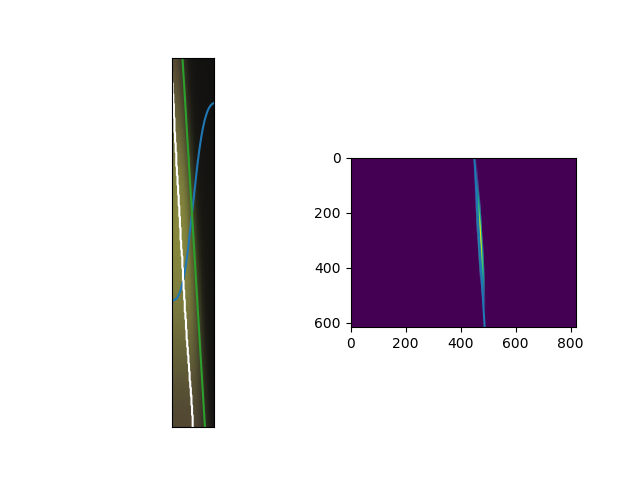

In [57]:
f, (ax, ax2) = plt.subplots(1,2)
thumbnail = thumbnails[0]
# Plot the image
ax.imshow(thumbnail)

# Plot the marginal distributions
w, h = thumbnail.shape[:2]
xmarginal = np.mean(np.mean(thumbnail, axis=2), axis=0)
ymarginal = np.mean(np.mean(thumbnail, axis=2), axis=1)
ax.plot(range(h), xmarginal/xmarginal.max()*h/2)
ax.plot(ymarginal/ymarginal.max()*h/2, range(w))

# tidy up the plot (hide axes)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

# Find the line (old method)
horizontal, falling = find_edge_orientation(thumbnail)
flipped = reorient_image(thumbnail, not horizontal, not falling) # why the nots???!
xs, ys = find_edge(flipped.sum(axis=2))
if horizontal:
    xs, ys = ys, xs
if falling:
    xs, ys = xs[::-1], ys[::-1]
ax.plot(xs, ys, color="white")

# Find the line (new method 1)
fuzz = 5
from scipy.ndimage.filters import gaussian_filter
#smooth_gray = gaussian_filter(thumbnail.mean(axis=2), fuzz)
#edges = np.diff(smooth_gray, axis=0)[:,:-1]**2 + np.diff(smooth_gray, axis=1)[:-1,:]**2
edges = gaussian_filter(thumbnail.mean(axis=2), fuzz, order=(0,1))**2
edges += gaussian_filter(thumbnail.mean(axis=2), fuzz, order=(1,0))**2
edges -= edges.max()*0.3
edges[edges<0] = 0
x = np.arange(edges.shape[0])[:,np.newaxis]
y = np.arange(edges.shape[1])[np.newaxis,:]
def expectation(function, weights):
    return np.mean(function * weights)/np.mean(weights)
cx = expectation(x, edges)
cy = expectation(y, edges)
Sxx = expectation((x-cx)**2, edges)
Syy = expectation((y-cy)**2, edges)
Sxy = expectation((x-cx)*(y-cy), edges)
if Sxx > Syy: # the line is ~horizontal
    gradient = Sxy/Sxx
    intercept = cy - cx * gradient
    horizontal_line = True
    for axes in (ax, ax2):
        axes.plot(intercept + gradient * x[:,0], x[:,0])
else: # we have a vertical-ish line
    gradient = Sxy/Syy
    intercept = cx - cy * gradient
    horizontal_line = False
    for axes in (ax, ax2):
        axes.plot(y[0,:], intercept + gradient * y[0,:])
ax2.imshow(edges)

<IPython.core.display.Javascript object>


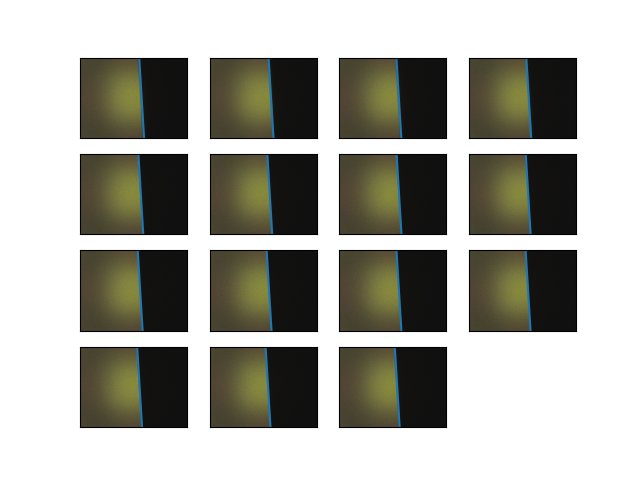

In [58]:
def locate_edge(image, fuzz=10):
    """Fit the peak gradients of the image with a straight line.
    
    Returns: (horizontal, line)
        horizontal: bool
            Whether the line is closer to horizontal than vertical.
        line: tuple of two floats (gradient, intercept)
            The equation of the line.  If "horizontal", y=gradient*x + intercept.
            If horizontal is false, then x=y*gradient + intercept.  x and y refer
            to the first and second array indices of the image respectively.
    """
    gray_image = image.mean(axis=2) if len(image.shape) == 3 else image
    # start with a non-directional edge detection
    from scipy.ndimage.filters import gaussian_filter
    edges = gaussian_filter(gray_image, fuzz, order=(0,1))**2
    edges += gaussian_filter(gray_image, fuzz, order=(1,0))**2
    # background-subtract to remove noise
    edges -= edges.max()*0.3
    edges[edges<0] = 0
    # calculate moments of the image
    x = np.arange(edges.shape[0])[:,np.newaxis]
    y = np.arange(edges.shape[1])[np.newaxis,:]
    def expectation(function, weights):
        return np.mean(function * weights)/np.mean(weights)
    cx = expectation(x, edges)
    cy = expectation(y, edges)
    Sxx = expectation((x-cx)**2, edges)
    Syy = expectation((y-cy)**2, edges)
    Sxy = expectation((x-cx)*(y-cy), edges)
    if Sxx > Syy: # the line is ~horizontal
        gradient = Sxy/Sxx
        intercept = cy - cx * gradient
        return True, (gradient, intercept)
    else: # we have a vertical-ish line
        gradient = Sxy/Syy
        intercept = cx - cy * gradient
        return false, (gradient, intercept)

def edge_is_falling(image, line):
    """Determine if an edge is white-to-black."""
    gray_image = image.mean(axis=2) if len(image.shape) == 3 else image
    return np.sum(gray_image[y < x*gradient + intercept]) > 0.5*np.sum(gray_image)


fig = plt.figure()
for i, thumbnail in enumerate(thumbnails):
    # Plot the image
    ax = fig.add_subplot((len(thumbnails) - 1)// 4 + 1, 4, i + 1)
    ax.imshow(thumbnail)
    
    # tidy up the plot (hide axes)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    # Find the line
    horizontal, line = locate_edge(thumbnail, fuzz=5)
    xs = np.arange(edges.shape[0])
    ys = np.arange(edges.shape[1])
    if horizontal:
        ax.plot(line[0]*xs + line[1], xs)
    else:
        ax.plot(ys, line[0]*ys + line[1])

<IPython.core.display.Javascript object>


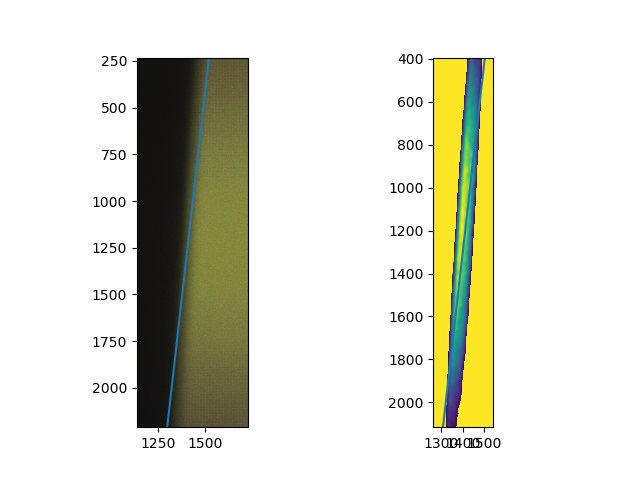

In [10]:
%autoreload
from analyse_edge_image import locate_edge, reorient_image
image = rgb_images[0]
vertical, falling, line = locate_edge(image, fuzz=10)

image = reorient_image(image, vertical, falling)

f, axes = plt.subplots(1,2)

ax = axes[0]
ax.imshow(image)
xs = np.arange(image.shape[0])
ys = np.arange(image.shape[1])
ax.plot(line[0]*xs + line[1], xs)

ax = axes[1]

fuzz=10
threshold=0.3
gray_image = image.mean(axis=2)
# start with a non-directional edge detection
from scipy.ndimage.filters import gaussian_filter
edges = gaussian_filter(gray_image, fuzz, order=(0,1))**2
edges += gaussian_filter(gray_image, fuzz, order=(1,0))**2
# background-subtract to remove bias due to nonzero background

edges -= edges.max()*threshold
edges[edges<0] = 0

edges[edges==0] = edges.max()
ax.imshow(edges)
ax.plot(line[0]*xs + line[1], xs)